# In which we use the [WayBack Machine](https://archive.org/web/) to scrape historical data on the number of signatures for the [Petition to Revoke Article 50 if Vote Leave Broke the Law](https://petition.parliament.uk/petitions/241584).


In [1]:
from datetime import datetime
import json
import string

from bs4 import BeautifulSoup
import ipywidgets as widgets
from ipywidgets import Layout
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import requests

## Rather helpfully, the WayBack Machine has an [API](https://github.com/internetarchive/wayback/tree/master/wayback-cdx-server).

In [2]:
def get_timestamps(url):
    req = requests.get('http://web.archive.org/cdx/search/cdx',
        params={'url': url, 'output': 'json'})
    return sorted(set([item[1] for item in req.json()[1:]]))

def extract_count(url,timestamp):
    req = requests.get('http://web.archive.org/web/{}/{}'.format(timestamp, url))
    soup = BeautifulSoup(req.content)
    return int(''.join(filter(lambda c: c in string.digits,
        soup.find('span', class_='count').text)))

def get_counts(url):
    timestamps = get_timestamps(url)
    counts = map(lambda t: extract_count(url,t), timestamps)
    times = map(lambda t: datetime.strptime(t, '%Y%m%d%H%M%S'), timestamps)
    return list(times), list(counts)

def get_title(url):
    soup = BeautifulSoup(requests.get(url).content)
    return soup.find('h1').contents[-1].strip()
    

In [3]:
def plot_signatures(title, times, counts):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))
    plt.gcf().autofmt_xdate()
    plt.xlabel('time', fontsize=20)
    plt.ylabel('signatures', fontsize=20)
    plt.title(title, fontsize=16)
    plt.plot(times,counts,  marker='o')
    plt.show()

In [4]:
revoke_art_50 = 'https://petition.parliament.uk/petitions/241584'

Text(value='https://petition.parliament.uk/petitions/241584', description='Petition URL', layout=Layout(width=…

Button(description='Get Petition History', style=ButtonStyle())

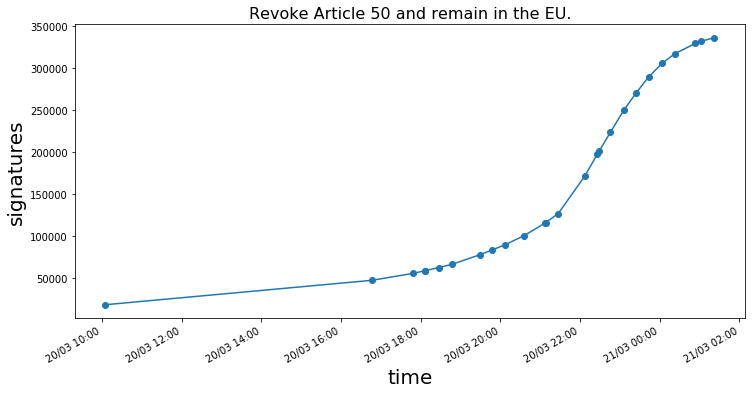

In [5]:
%matplotlib inline

go_button = widgets.Button(description="Get Petition History")

url_text = widgets.Text(
    value=revoke_art_50,
    placeholder='petition URL',
    description='Petition URL',
    layout=Layout(width='75%'),
    hidden=False)

def on_button_clicked(button):
    url = url_text.value
    times, counts = get_counts(url)
    title = get_title(url)
    plot_signatures(title, times, counts)
    
go_button.on_click(on_button_clicked)
    
display(url_text)   
display(go_button)

## Try it with any [UK Parliament Petition](https://petition.parliament.uk/) you like...

# There was also the [Petition to Rescind Article 50 if Vote Leave Broke the Law](https://petition.parliament.uk/petitions/223729).
## Spoilers: People get really into it when it becomes brutally obvious that [Vote Leave did break the law](https://www.theguardian.com/politics/2018/jul/17/vote-leave-broke-electoral-law-and-british-democracy-is-shaken).

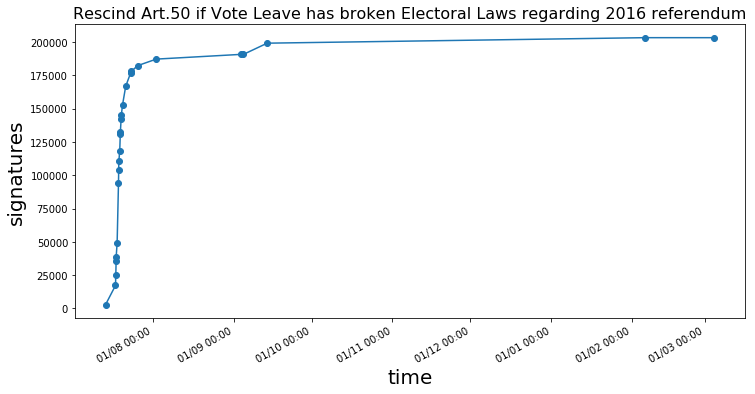

In [6]:
url = 'https://petition.parliament.uk/petitions/223729'
times, counts = get_counts(url)
title = get_title(url)
plot_signatures(title, times, counts)

## ~100K signatures were reached at 2100 18/07/18, we only get data points when the WayBack Machine takes a snapshot.

In [7]:
print(json.dumps(list(zip(map(lambda t: t.isoformat(),times),counts))))

[["2018-07-13T19:45:01", 2775], ["2018-07-17T15:48:45", 17219], ["2018-07-17T18:42:37", 25370], ["2018-07-17T21:38:14", 35911], ["2018-07-17T22:15:05", 38820], ["2018-07-18T06:56:07", 49418], ["2018-07-18T19:22:33", 94005], ["2018-07-18T21:16:23", 104136], ["2018-07-18T22:50:29", 110524], ["2018-07-19T06:58:55", 118385], ["2018-07-19T12:11:46", 131251], ["2018-07-19T12:48:44", 132367], ["2018-07-19T19:22:45", 141980], ["2018-07-19T21:04:42", 144840], ["2018-07-20T08:23:42", 152625], ["2018-07-21T13:58:56", 166790], ["2018-07-23T12:34:01", 176980], ["2018-07-23T17:45:49", 177881], ["2018-07-26T02:41:37", 182196], ["2018-08-02T07:48:00", 187142], ["2018-09-03T20:03:41", 190687], ["2018-09-04T19:38:19", 190707], ["2018-09-13T22:22:22", 199098], ["2019-02-05T23:25:02", 203230], ["2019-03-04T15:16:50", 203230]]
